In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [2]:
sys.path.append("C:\\Users\josep\Downloads")

In [3]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [4]:
list(f.keys())

['DSV_00', 'U', 'Uk', 'eta', 'k', 't', 'x', 'y', 'z']

In [32]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [6]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [7]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

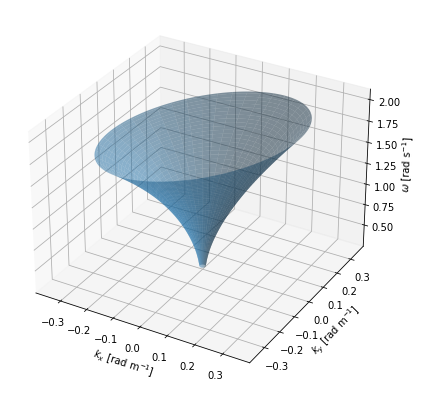

In [8]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=100, z = z, U = U, psi = 0)

In [180]:
def plot_disp_relation_and_points_at_theta(spec_theta, thresh_freq, max_freq, step_size, h, z, U, psi):
    '''
    This function finds the relationship between triplets found from spectrum from FFT 
    and the dispersion relation at specific theta. 
    It plots it in the Radial vs Omega Space. 
    '''
    
    # (1) TRIPLET POINTS
    
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    # This gets the triplets points 
    # Triplets are (max_kx, mak_ky, freqs)
    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:]-f))
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the spectrum values represented by colour
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
        
    kx = np.array(kx_list)
    ky = np.array(ky_list)
    
    # transform Triplets to polar coordinates
    r = np.sqrt( (kx)**2 + (ky)**2 )
    theta = np.arctan2(ky,kx)
    
    # (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.scatter(r, freqs, color = 'red', zorder=1, label = 'Triplets')
    plt.plot(disp_r,disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()
    
    return r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta

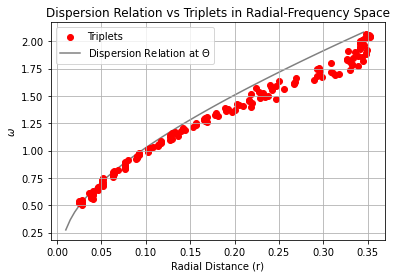

In [181]:
r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta = plot_disp_relation_and_points_at_theta(0, thresh_freq = 0.5 , 
                                                  max_freq = 2.08, step_size = 0.01, h=100, 
                                                  z = z, U=U, psi = 0)

# Consider Exact Dispersion Relation

In [182]:
DWL_kx = np.arange(0.01, 0.35, 0.0001)
DWL_ky = np.arange(0.01, 0.35, 0.0001)
# DWL = deep water limit

DWL_omega = np.sqrt( 9.81 * np.sqrt( (DWL_kx)**2  + (DWL_ky)**2 ) )
# DWL formula

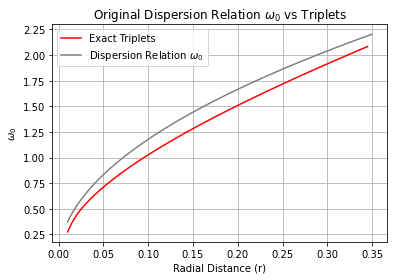

In [183]:
plt.plot(disp_r,disp_ww_for_theta, color = 'red', label = 'Exact Triplets')
plt.plot(DWL_kx, DWL_omega, color='grey', label = 'Dispersion Relation $\omega_{0}$')

#plt.scatter(disp_r, np.sqrt(9.81 * disp_r) +disp_r*Uk[:,0][indices], label='Triplets $\omega$ using Correct U', color = 'red', s = 1)

plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega_{0}$')
plt.title("Original Dispersion Relation $\omega_{0}$ vs Triplets")
plt.legend()

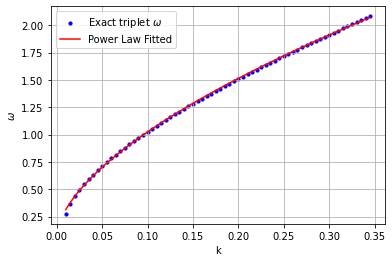

In [184]:
# Use fitting function
def power_law_function(x, a, b, c):
    return a * x**b + c

# Fit the curve
param, covariance = curve_fit(power_law_function, disp_r, disp_ww_for_theta)
a, b, c = param

# Fitted curve points
k_fit = np.linspace(min(disp_r), max(disp_r), len(disp_r))
y_fit = power_law_function(k_fit, a, b, c)

# Plot data and fitted curve
plt.scatter(disp_r,disp_ww_for_theta, label='Exact triplet $\omega$ ', s=10, color='blue')
plt.plot(k_fit, y_fit, label='Power Law Fitted', color='red')

plt.ylabel('$\omega$')
plt.xlabel('k')
plt.grid(True)
plt.legend()

In [185]:
DWL_kx = np.arange(0.01, 0.35, 0.005)
DWL_ky = np.arange(0.01, 0.35, 0.005)

In [186]:
w_0 = np.sqrt( 9.81 * disp_r )
# DWL formula

In [187]:
y_fit.shape

(68,)

In [188]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = np.zeros(len(disp_r))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=( y_fit, w_0, disp_r))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

Optimized U values: [ 0.0279423  -0.3007112  -0.3311222  -0.28749359 -0.22481557 -0.15985311
 -0.09810588 -0.04123046  0.01052672  0.05743839  0.0999478   0.13852828
  0.17362809  0.20565124  0.2349535   0.26184494  0.28659453  0.30943542
  0.33056992  0.35017394  0.36840093  0.38538509  0.40124426  0.41608222
  0.42999069  0.443051    0.45533547  0.46690864  0.47782822  0.48814599
  0.49790849  0.50715768  0.51593141  0.52426394  0.53218631  0.5397267
  0.54691071  0.55376163  0.56030072  0.56654735  0.57251927  0.57823269
  0.58370251  0.58894241  0.59396498  0.59878186  0.6034038   0.60784077
  0.61210203  0.61619621  0.62013137  0.62391505  0.62755432  0.63105582
  0.6344258   0.63767017  0.64079448  0.64380401  0.64670373  0.64949837
  0.6521924   0.65479007  0.65729541  0.65971227  0.66204428  0.6642949
  0.66646745  0.66856504]


In [189]:
optimized_U.shape

(68,)

In [190]:
indices = np.array([]) 
k_reshaped = k.reshape(-1, 1)

# Absolute differences between r and k values
differences = np.abs(disp_r - k_reshaped)

# Indices of the minimum differences for each element in k
indices = np.argmin(differences, axis=0)

Text(0.5, 0, 'k')

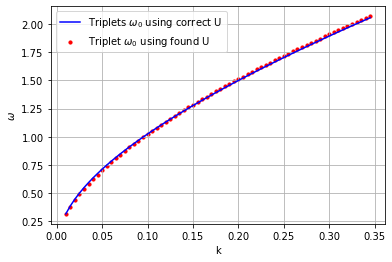

In [191]:
#plt.scatter(k, correct_w_trips, s = 1, label="correct Triplets w")
plt.plot(disp_r, w_0+disp_r*Uk[:,0][indices], label="Triplets $\omega_{0}$ using correct U ", color = 'blue',)
plt.scatter(disp_r, w_0+disp_r*optimized_U, label='Triplet $\omega_{0}$ using found U', color = 'red', s = 10)

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

In [192]:
disp_r.shape

(68,)

In [193]:
optimized_U.shape

(68,)

Text(0.5, 0, 'k')

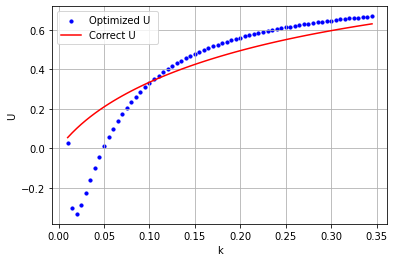

In [194]:
plt.scatter(disp_r, optimized_U, label='Optimized U ', color='blue', s = 10)
plt.plot(disp_r, Uk[:,0][indices], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

#plt.xlim(0.15, 0.35)
#plt.ylim(0,1)

# Consider Triplet Values

In [113]:
DWL_kx = np.arange(0.01, 0.35, 0.0001)
DWL_ky = np.arange(0.01, 0.35, 0.0001)
# DWL = deep water limit

DWL_omega = np.sqrt( 9.81 * np.sqrt( (DWL_kx)**2  + (DWL_ky)**2 ) )
# DWL formula

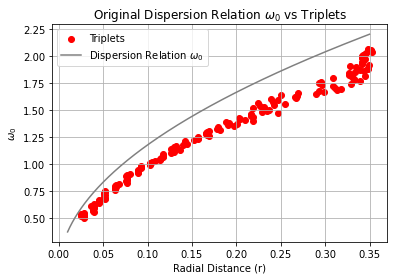

In [114]:
plt.scatter(r, freqs, color = 'red', label = 'Triplets')
plt.plot(DWL_kx, DWL_omega, color='grey', label = 'Dispersion Relation $\omega_{0}$')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega_{0}$')
plt.title("Original Dispersion Relation $\omega_{0}$ vs Triplets")
plt.legend()

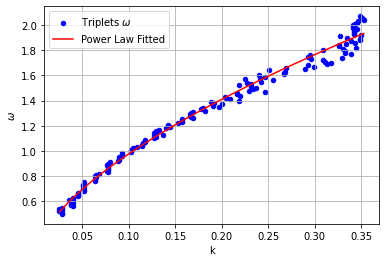

In [115]:
# Use fitting function
def power_law_function(x, a, b, c):
    return a * x**b + c

# Fit the curve
param, covariance = curve_fit(power_law_function, r, freqs)
a, b, c = param

# Fitted curve points
k_fit = np.linspace(min(r), max(r), len(r))
y_fit = power_law_function(k_fit, a, b, c)

# Plot data and fitted curve
plt.scatter(r, freqs, label='Triplets $\omega$ ', s=20, color='blue')
plt.plot(k_fit, y_fit, label='Power Law Fitted', color='red')

plt.ylabel('$\omega$')
plt.xlabel('k')
plt.grid(True)
plt.legend()

In [116]:
kx_0 = r
ky_0 = r
# DWL = deep water limit

w_0 = np.sqrt( 9.81 * r )
# DWL formula

In [117]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = np.zeros(len(r))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=( y_fit, w_0,r))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

Optimized U values: [-4.05767692e-01  1.65537564e-01  1.87786909e+00  1.26825214e+00
  3.10368003e+00  2.33556445e+00 -3.49380608e-01  4.02416217e-01
  7.67082447e-01  6.81551689e-01  1.01870268e+00  2.43220809e+00
  1.68320927e+00  2.00935035e+00  1.14125012e+00  1.41855169e+00
  1.69270049e+00  1.96363959e+00  1.08592750e+00  1.31649954e+00
  1.79938379e+00  1.77053611e+00  2.26296584e+00  2.49126281e+00
  2.43461666e+00  2.65173814e+00  1.24509423e+00  1.42007044e+00
  1.59358342e+00  1.61361388e+00  1.93636101e+00  1.94686438e+00
  1.68250932e+00  9.72773163e-01  1.19981732e+00  1.24231059e+00
  1.37570054e+00  1.50818521e+00  1.63977469e+00  1.87170821e+00
  1.90031180e+00  1.74147243e+00  1.17264384e+00  1.21816982e+00
  1.32666923e+00  1.43452285e+00  1.35050751e+00  1.45396304e+00
  1.55681866e+00  1.01752250e+00  1.10912902e+00  1.20024556e+00
  1.15485396e+00  1.03450410e+00  8.27557985e-01  9.07238546e-01
  9.52551225e-01  9.31712773e-01  1.00831179e+00  1.08454114e+00
  7.2

In [118]:
indices = np.array([]) 
k_reshaped = k.reshape(-1, 1)

# Absolute differences between r and k values
differences = np.abs(r - k_reshaped)

# Indices of the minimum differences for each element in k
indices = np.argmin(differences, axis=0)

Text(0.5, 0, 'k')

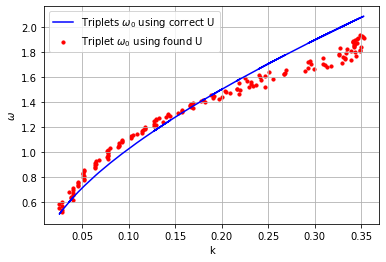

In [119]:
#plt.scatter(k, correct_w_trips, s = 1, label="correct Triplets w")
plt.plot(r, w_0+r*Uk[:,0][indices], label="Triplets $\omega_{0}$ using correct U ", color = 'blue',)
plt.scatter(r, w_0+r*optimized_U, label='Triplet $\omega_{0}$ using found U', color = 'red', s = 10)

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

Text(0.5, 0, 'k')

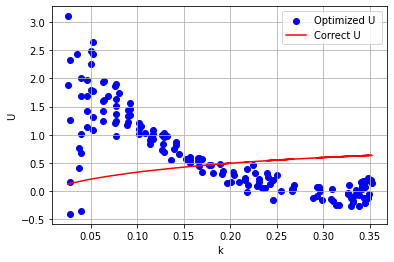

In [120]:
plt.scatter(r, optimized_U, label='Optimized U ', color='blue')
plt.plot(r, Uk[:,0][indices], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

#plt.xlim(0.15, 0.35)
#plt.ylim(0,1)